## Project 4. Functional connectivity analysis during motor imagery using fMRI

#### Installing Packages

In [30]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import pandas as pd
from nilearn import input_data, plotting, image
import os
from tqdm import tqdm
import pandas as pd



#### First we had to extract the files from the compressed (.tar.bz2) extension

## PART I - Compute Average Functional Connectomes

### 1. Load the files

We need to load the data (the NIFTI files for each image), the NIFTI of the atlas and the Atlas Label Locations

The current version of the code only loads one image belonging to subject 12, first scenario.

In [61]:
# Define paths (adjust these to your data location)
data_path = 'Project4/sub-17'
atlas_path = 'Schaefer_100parcels_7Networks/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_2mm.nii.gz'
lut_path = 'Schaefer_100parcels_7Networks/Schaefer2018_100Parcels_7Networks_order.lut'
# Load the atlas
atlas_img = nib.load(atlas_path)

In [62]:
project_path = 'Project4'

task_graz_files = []
neurowMI_files = []
rest_files = []

def join_files_by_condition(project_path):
    """Categorizes files in the project directory into task_graz, neurowMI, and rest conditions."""
    task_graz_files = []
    neurowMI_files = []
    rest_files = []

    for folder in os.listdir(project_path):
        folder_path = os.path.join(project_path, folder)
        if os.path.isdir(folder_path):  # Ensure it's a directory
            for file in os.listdir(folder_path):
                file_name = os.path.join(folder_path, file)
                if "graz" in file_name:
                    task_graz_files.append(file_name)
                elif "neurowMI" in file_name:
                    neurowMI_files.append(file_name)
                elif "rest" in file_name:
                    rest_files.append(file_name)

    return task_graz_files, neurowMI_files, rest_files

# Example usage:
task_graz_files, neurowMI_files, rest_files = join_files_by_condition(project_path)
print("Task Graz Files:", task_graz_files)
print("NeurowMI Files:", neurowMI_files)
print("Rest Files:", rest_files)

Task Graz Files: ['Project4/sub-13/sub-13_ses-inside1_task-grazMI_run-03_filtered_func_data2standard.nii.gz', 'Project4/sub-13/sub-13_ses-inside1_task-grazMI_run-02_filtered_func_data2standard.nii.gz', 'Project4/sub-13/sub-13_ses-inside1_task-grazMI_run-01_filtered_func_data2standard.nii.gz', 'Project4/sub-14/sub-14_ses-inside1_task-grazMI_run-02_filtered_func_data2standard.nii.gz', 'Project4/sub-14/sub-14_ses-inside1_task-grazMI_run-03_filtered_func_data2standard.nii.gz', 'Project4/sub-14/sub-14_ses-inside1_task-grazMI_run-01_filtered_func_data2standard.nii.gz', 'Project4/sub-12/sub-12_ses-inside1_task-grazMI_run-02_filtered_func_data2standard.nii.gz', 'Project4/sub-12/sub-12_ses-inside1_task-grazMI_run-03_filtered_func_data2standard.nii.gz', 'Project4/sub-12/sub-12_ses-inside1_task-grazMI_run-01_filtered_func_data2standard.nii.gz', 'Project4/sub-17/sub-17_ses-inside1_task-grazMI_run-01_filtered_func_data2standard.nii.gz', 'Project4/sub-17/sub-17_ses-inside1_task-grazMI_run-03_filtere

### Plotting the Atlas to see the regions

The image shows teh distribution of the 100 regions of the Schaefer Atlas

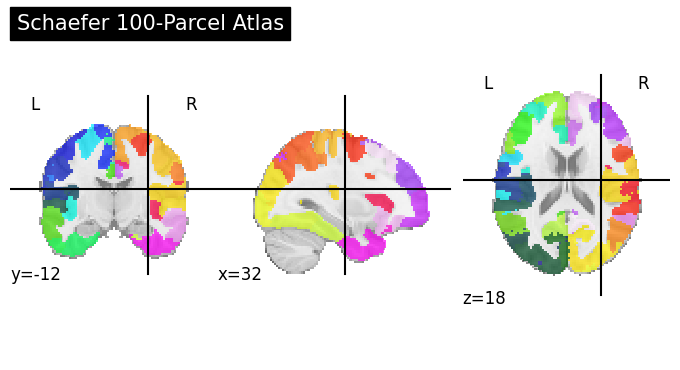

In [63]:
# Plot the atlas on a standard template
display = plotting.plot_roi(atlas_img, title="Schaefer 100-Parcel Atlas")
plt.savefig('atlas_visualization.png')
plt.show()

In [34]:
# Visualize the atlas in 3D
view = plotting.view_img(atlas_img, title="Schaefer 100-Parcel Atlas (3D View)")

/Users/joaomata/Desktop/NeuroProject/.venv/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:868: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


### Name all the 100 regions

Get the names from the .LUT file

In [64]:

# Define the network prefixes for both hemispheres
network_prefixes = ['7Networks_LH_Vis', '7Networks_LH_SomMot', '7Networks_LH_DorsAttn', 
                    '7Networks_LH_SalVentAttn', '7Networks_LH_Limbic', '7Networks_LH_Cont', 
                    '7Networks_LH_Default', '7Networks_RH_Vis', '7Networks_RH_SomMot', 
                    '7Networks_RH_DorsAttn', '7Networks_RH_SalVentAttn', '7Networks_RH_Limbic', 
                    '7Networks_RH_Cont', '7Networks_RH_Default']

def load_region_names(lut_path):
    try:
        # Load LUT file assuming space-separated values
        lut_df = pd.read_csv(lut_path, sep=r'\s+', header=None, names=['ID', 'R', 'G', 'B', 'Region'])
        
        # Ensure we have at least 100 regions
        if len(lut_df) < 100:
            raise ValueError(f"LUT file  contains only {len(lut_df)} regions, expected 100.")

        return lut_df['Region'].tolist()  # Extract and return region names
    
    except Exception as e:
        print(f"Error loading LUT file: {e}")
        return [f"Region_{i+1}" for i in range(100)]  # Fallback default names

# Example usage:
region_names = load_region_names(lut_path)
print(f"Loaded {len(region_names)} regions: {region_names[:5]}")


Loaded 100 regions: ['7Networks_LH_Vis_1', '7Networks_LH_Vis_2', '7Networks_LH_Vis_3', '7Networks_LH_Vis_4', '7Networks_LH_Vis_5']


### Yeo's 7 Networks for reference

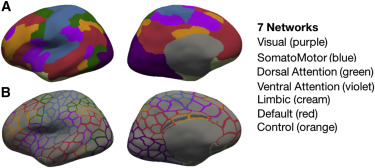

In [77]:
def extract_time_series(fmri_img, atlas_img):
    """Extracts time series from fMRI data using a given atlas."""
    # Create a masker to extract time series from each region
    masker = input_data.NiftiLabelsMasker(
        labels_img=atlas_img,
        standardize=True,  # Z-score normalization
        memory='nilearn_cache',  # Cache results
        verbose=0)

    # Extract time series
    time_series = masker.fit_transform(fmri_img)
    #print(f"Time series shape: {time_series.shape}")
    return time_series

time_series = extract_time_series(fmri_img, atlas_img)

In [67]:

def plot_network_time_series(time_series, region_names, network_prefixes, output_dir='Images'):
    """Plots the time series for each network and saves the plots as images."""
    # Create a dictionary to hold the indices of regions for each network
    network_indices = {prefix: [] for prefix in network_prefixes}

    # Populate the dictionary with indices
    for idx, region in enumerate(region_names):
        for prefix in network_prefixes:
            if region.startswith(prefix):
                network_indices[prefix].append(idx)
                break

    # Plot time series for each network
    for prefix, indices in network_indices.items():
        fig, ax = plt.subplots(len(indices), 1, figsize=(15, len(indices) * 2), sharex=True)
        for i, region_idx in enumerate(indices):
            ax[i].plot(time_series[:, region_idx])
            ax[i].set_title(f"Region: {region_names[region_idx]}")
            ax[i].set_ylabel("BOLD Signal (z-scored)")

        ax[-1].set_xlabel("Time (TR)")
        plt.tight_layout()
        plt.savefig(f'{output_dir}/time_series_{prefix}.png')
        plt.show()

# Example usage:
#plot_network_time_series(time_series, region_names, network_prefixes)


{'7Networks_LH_Vis': [0, 1, 2, 3, 4, 5, 6, 7, 8], '7Networks_LH_SomMot': [9, 10, 11, 12, 13, 14], '7Networks_LH_DorsAttn': [15, 16, 17, 18, 19, 20, 21, 22], '7Networks_LH_SalVentAttn': [23, 24, 25, 26, 27, 28, 29], '7Networks_LH_Limbic': [30, 31, 32], '7Networks_LH_Cont': [33, 34, 35, 36], '7Networks_LH_Default': [37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49], '7Networks_RH_Vis': [50, 51, 52, 53, 54, 55, 56, 57], '7Networks_RH_SomMot': [58, 59, 60, 61, 62, 63, 64, 65], '7Networks_RH_DorsAttn': [66, 67, 68, 69, 70, 71, 72], '7Networks_RH_SalVentAttn': [73, 74, 75, 76, 77], '7Networks_RH_Limbic': [78, 79], '7Networks_RH_Cont': [80, 81, 82, 83, 84, 85, 86, 87, 88], '7Networks_RH_Default': [89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]}


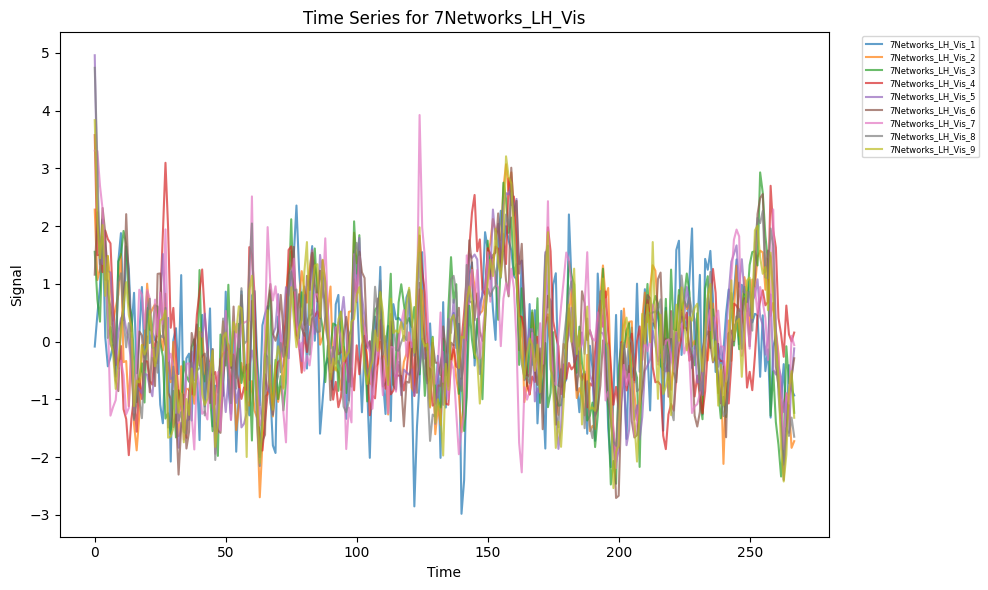

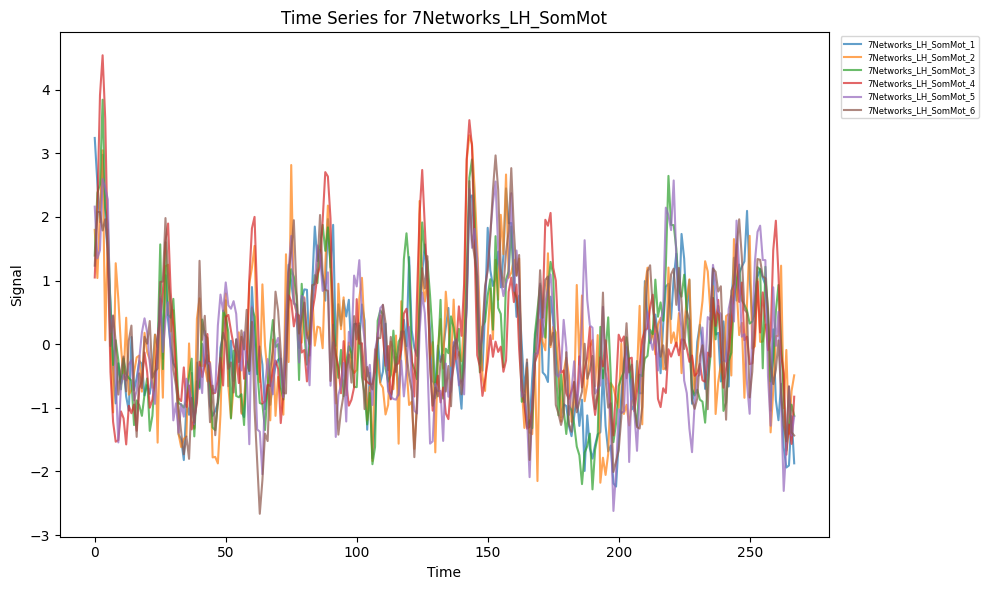

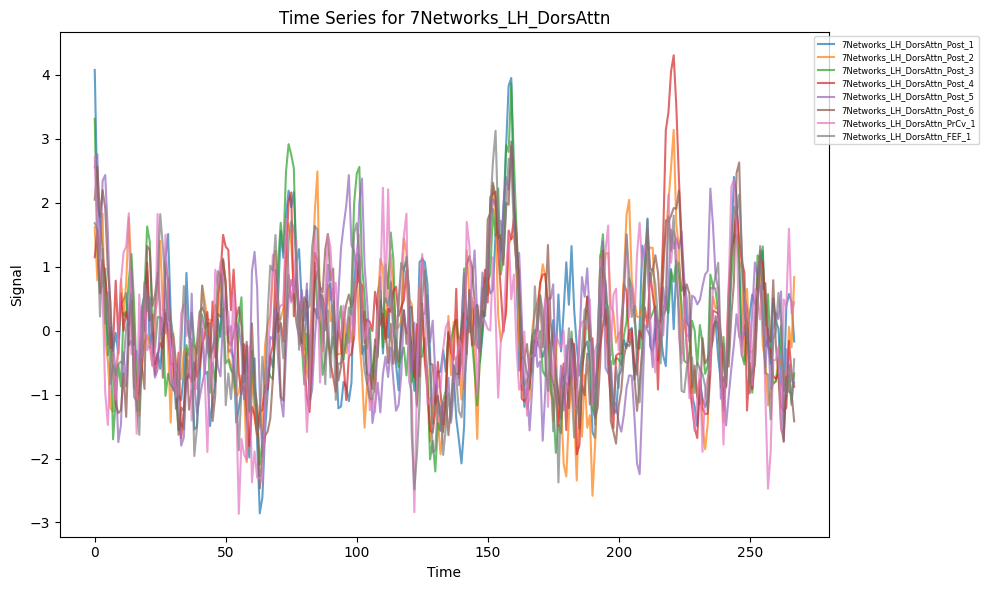

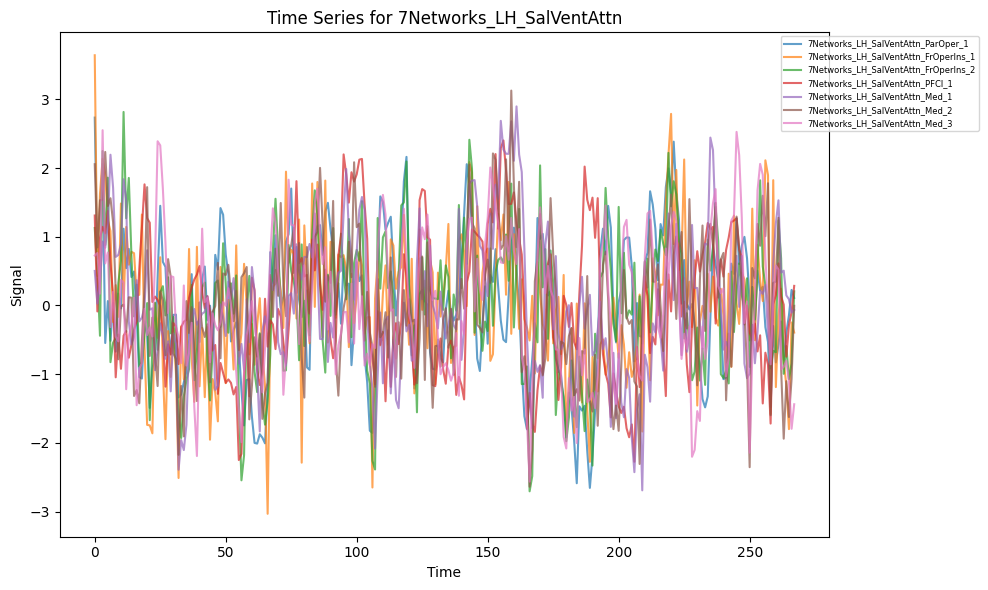

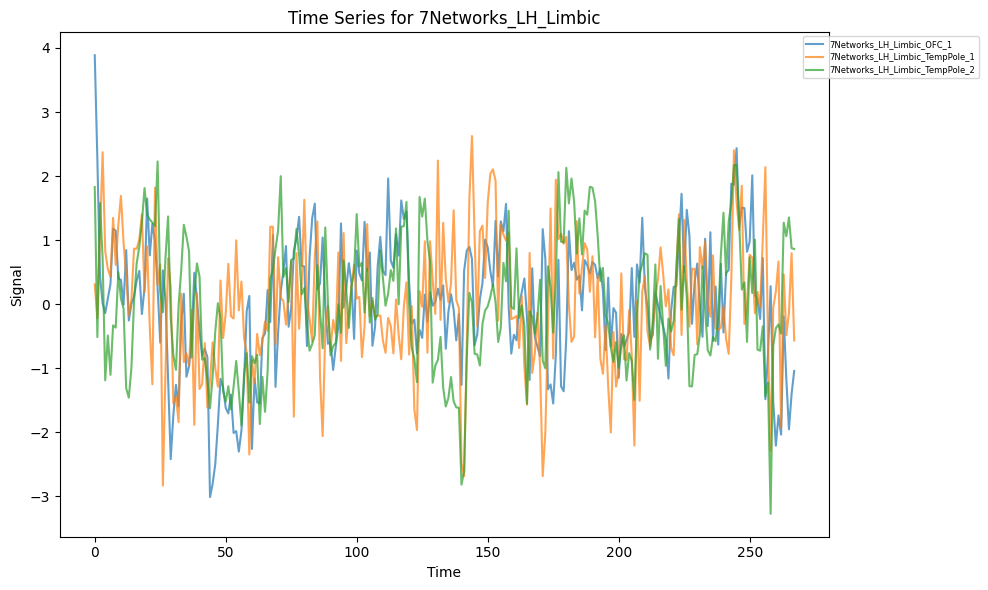

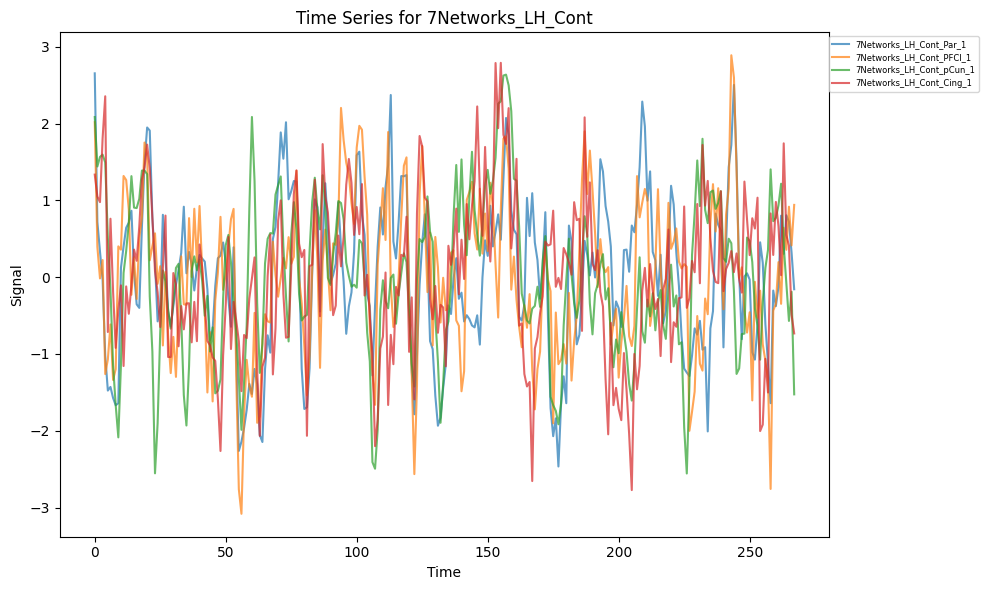

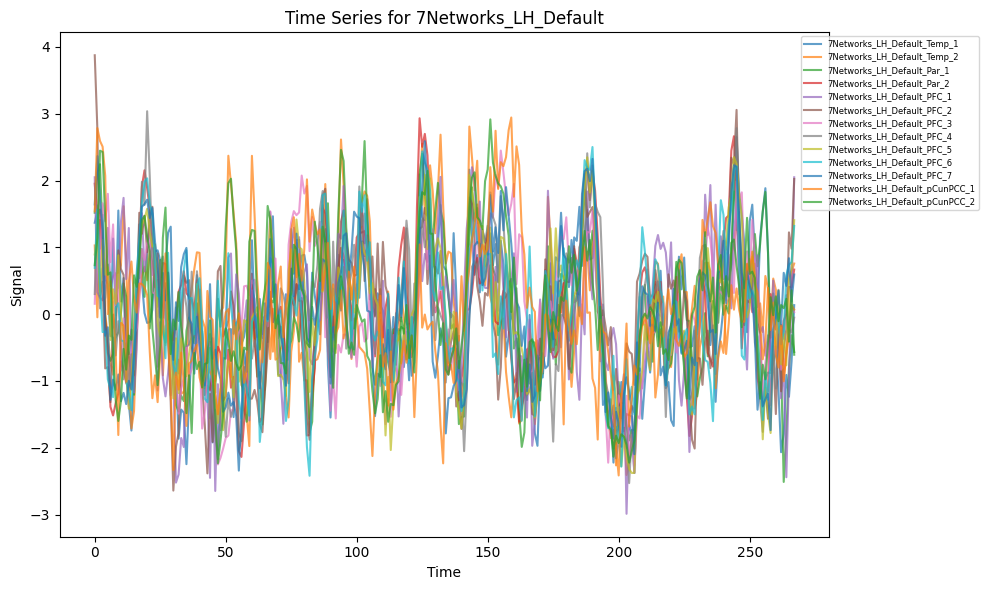

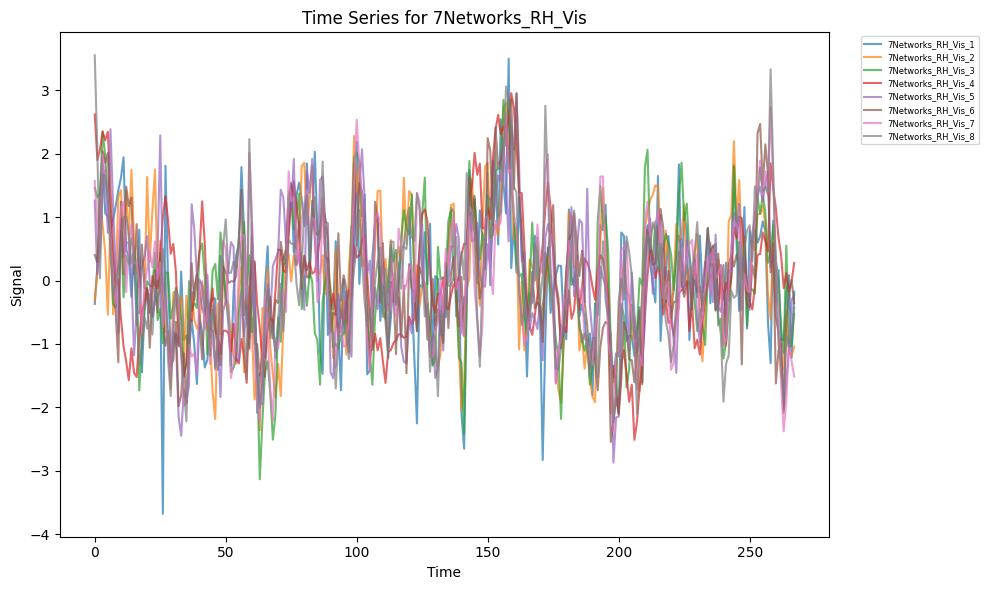

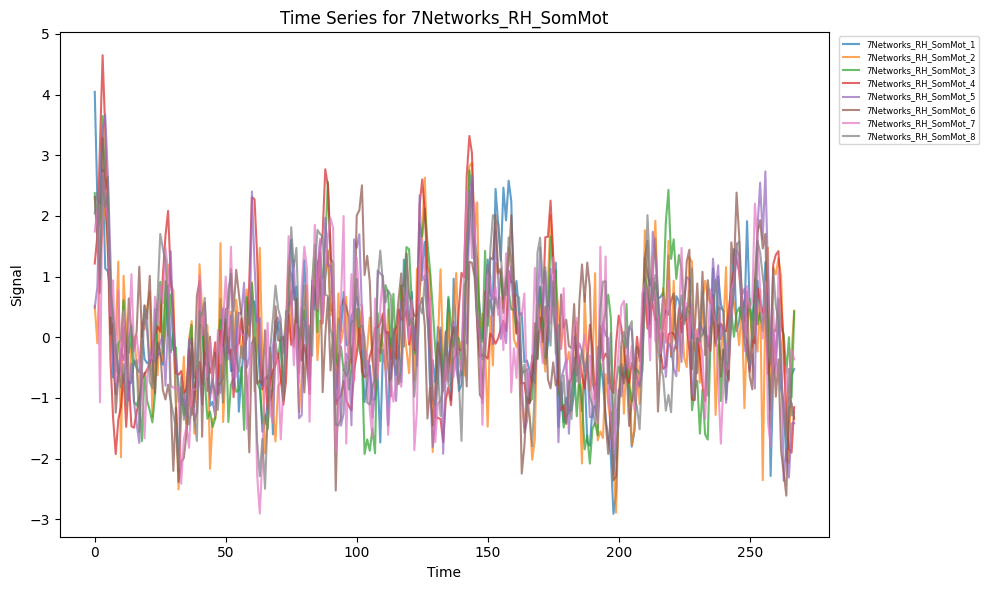

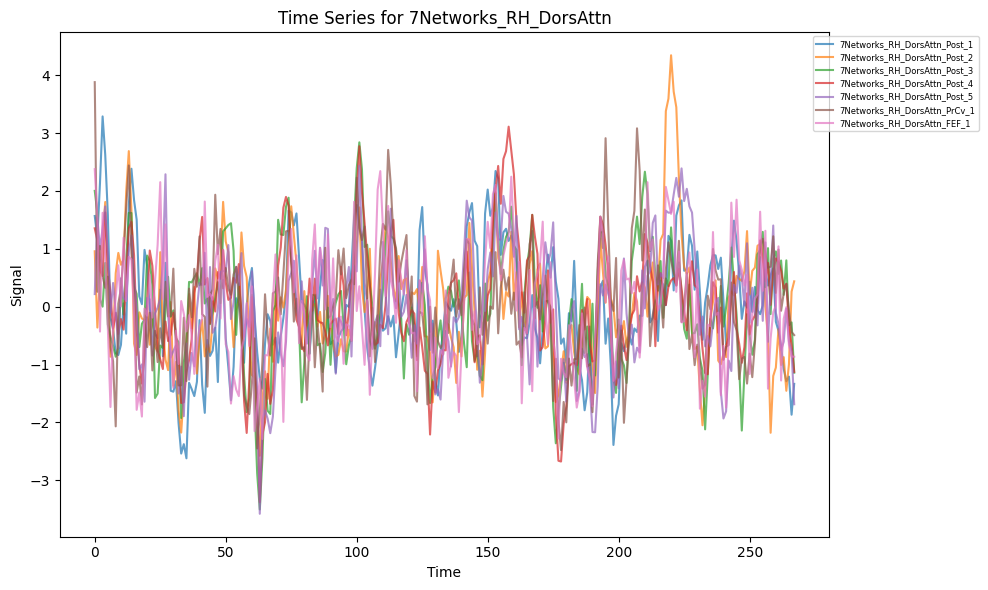

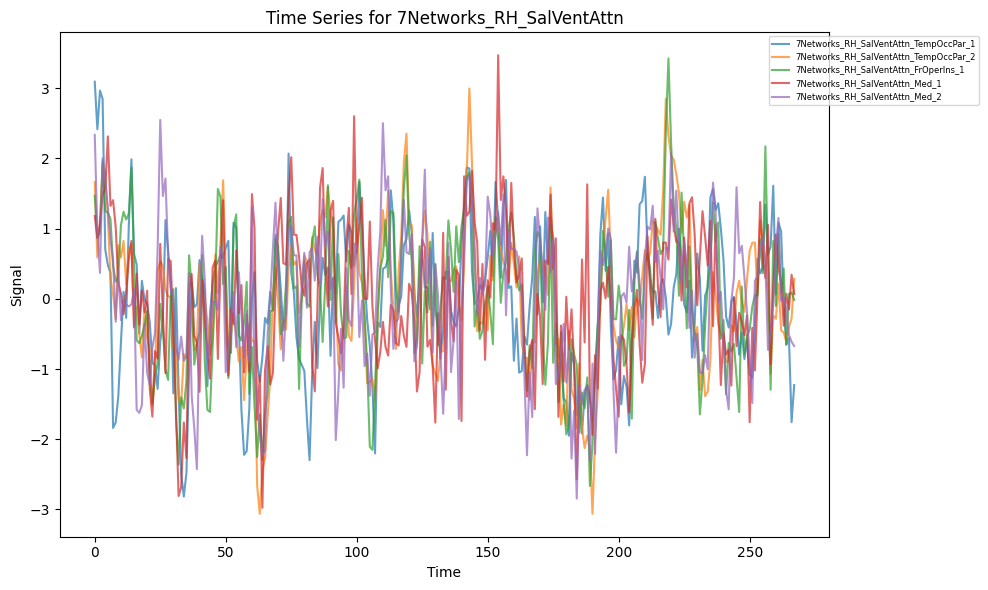

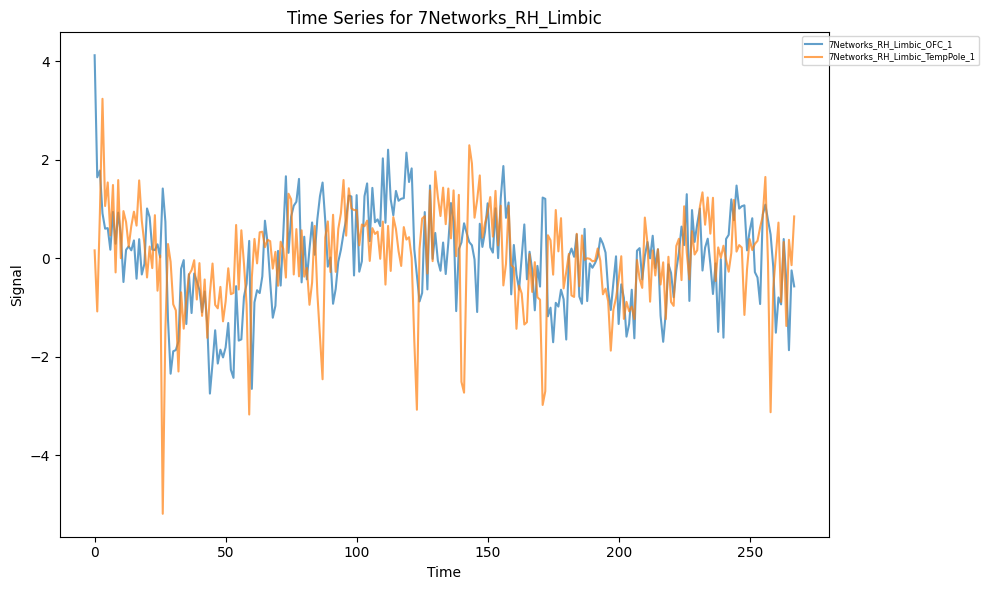

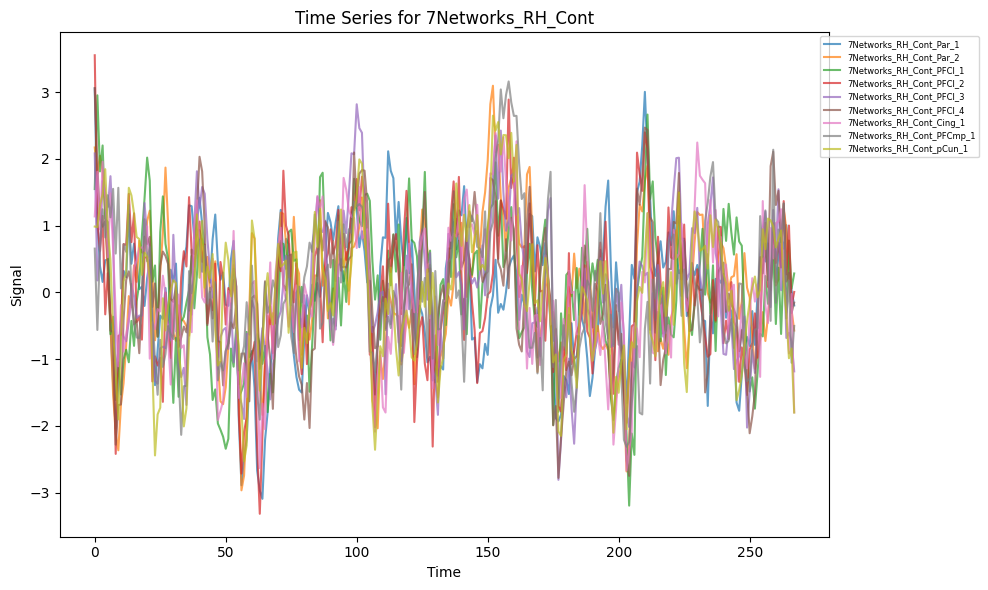

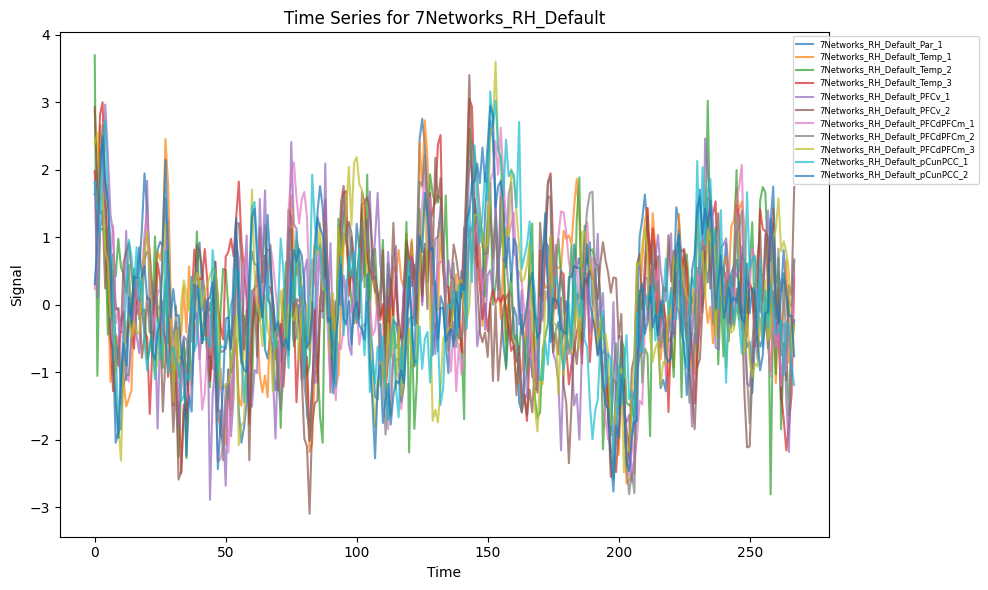

In [71]:
import numpy as np
import matplotlib.pyplot as plt

# Create a dictionary to hold the indices of regions for each network
network_indices = {prefix: [] for prefix in network_prefixes}

# Populate the dictionary with indices
for idx, region in enumerate(region_names):
    for prefix in network_prefixes:
        if region.startswith(prefix):
            network_indices[prefix].append(idx)
            break
print(network_indices)
        
for network_to_analyze in network_prefixes:
    # Get the indices of the regions in the specified network
    region_indices = network_indices[network_to_analyze]

    # Extract the time series for these regions
    network_time_series = time_series[:, region_indices]

    # Plot time series for all regions in the network
    plt.figure(figsize=(10, 6))
    
    for i, region_idx in enumerate(region_indices):
        plt.plot(network_time_series[:, i], label=region_names[region_idx], alpha=0.7)

    plt.xlabel('Time')
    plt.ylabel('Signal')
    plt.title(f'Time Series for {network_to_analyze}')
    plt.legend(fontsize=6, loc='upper right', bbox_to_anchor=(1.2, 1))
    plt.tight_layout()
    plt.savefig(f'Images/time_series_{network_to_analyze}.png')
    plt.show()


In [ ]:
def calculate_and_plot_correlation_matrix(time_series, region_names, output_path='Images/correlation_matrix.png'):
    """Calculate the Pearson correlation matrix for the given time series and plot it."""
    # Calculate the Pearson correlation matrix
    correlation_matrix = np.corrcoef(time_series.T)
    
    # Print the maximum and minimum correlation values
    max_corr = np.max(correlation_matrix)
    min_corr = np.min(correlation_matrix)
    
    print(f"Second maximum correlation value (distinct from max): {max_corr}")
    print(f"Minimum correlation value: {min_corr}")

    # Plot the correlation matrix
    plt.figure(figsize=(10, 8))
    plt.imshow(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1)
    plt.colorbar(label='Correlation Coefficient')
    plt.title('Functional Connectivity Correlation Matrix')
    plt.xlabel('Regions')
    plt.ylabel('Regions')
    plt.xticks(ticks=np.arange(len(region_names)), labels=region_names, rotation=90, fontsize=6)
    plt.yticks(ticks=np.arange(len(region_names)), labels=region_names, fontsize=6)
    plt.tight_layout()
    plt.savefig(output_path)
    plt.show()

    # Save the correlation matrix as numpy array
    np.save('correlation_matrix.npy', correlation_matrix)
    
    return correlation_matrix

# Example usage:
#correlation_matrix = calculate_and_plot_correlation_matrix(time_series, region_names)

#print(correlation_matrix.shape)



In [76]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

def calculate_and_plot_correlation_matrix(time_series, region_names, output_path='Images/correlation_matrix.png'):
    """
    Calculates and plots the functional connectivity correlation matrix.

    Parameters:
    - time_series: numpy array of shape (n_regions, n_timepoints)
    - region_names: list of n_regions names (e.g., Schaefer parcel labels)
    - output_path: path to save the heatmap image
    """
    # Compute correlation matrix
    correlation_matrix = np.corrcoef(time_series)

    # Create mask for upper triangle
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

    # Generate xtick and ytick labels with grouping by prefix
    xticks_labels = []
    yticks_labels = []
    last_prefix_x = None
    last_prefix_y = None

    for name in region_names:
        prefix = '_'.join(name.split('_')[1:3])  # e.g., 'LH_Vis'
        
        if prefix != last_prefix_x:
            xticks_labels.append(prefix)
            last_prefix_x = prefix
        else:
            xticks_labels.append('')

        if prefix != last_prefix_y:
            yticks_labels.append(prefix)
            last_prefix_y = prefix
        else:
            yticks_labels.append('')

    # Create plot
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(correlation_matrix,
                annot=False,
                fmt='.2f',
                linewidths=0.5,
                cmap='RdBu_r',
                mask=mask,
                xticklabels=xticks_labels,
                yticklabels=yticks_labels,
                cbar_kws={'label': 'Correlation Coefficient'},
                ax=ax)

    plt.title('Functional Connectivity Correlation Matrix', fontsize=14)
    plt.tight_layout()

    # Ensure output directory exists
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    plt.savefig(output_path, dpi=300)
    plt.close()

correlation_matrix = calculate_and_plot_correlation_matrix(time_series, region_names)



Calculating correlation between 7Networks_LH_Vis and 7Networks_LH_Vis
0.5817246312396732
Calculating correlation between 7Networks_LH_Vis and 7Networks_LH_SomMot
0.4542562099515241
Calculating correlation between 7Networks_LH_Vis and 7Networks_LH_DorsAttn
0.3918978176606632
Calculating correlation between 7Networks_LH_Vis and 7Networks_LH_SalVentAttn
0.3243115513077042
Calculating correlation between 7Networks_LH_Vis and 7Networks_LH_Limbic
0.21620292414457068
Calculating correlation between 7Networks_LH_Vis and 7Networks_LH_Cont
0.25847385002455
Calculating correlation between 7Networks_LH_Vis and 7Networks_LH_Default
0.2476803090868802
Calculating correlation between 7Networks_LH_Vis and 7Networks_RH_Vis
0.5335426677543693
Calculating correlation between 7Networks_LH_Vis and 7Networks_RH_SomMot
0.4008637806788957
Calculating correlation between 7Networks_LH_Vis and 7Networks_RH_DorsAttn
0.33116134381038587
Calculating correlation between 7Networks_LH_Vis and 7Networks_RH_SalVentAttn


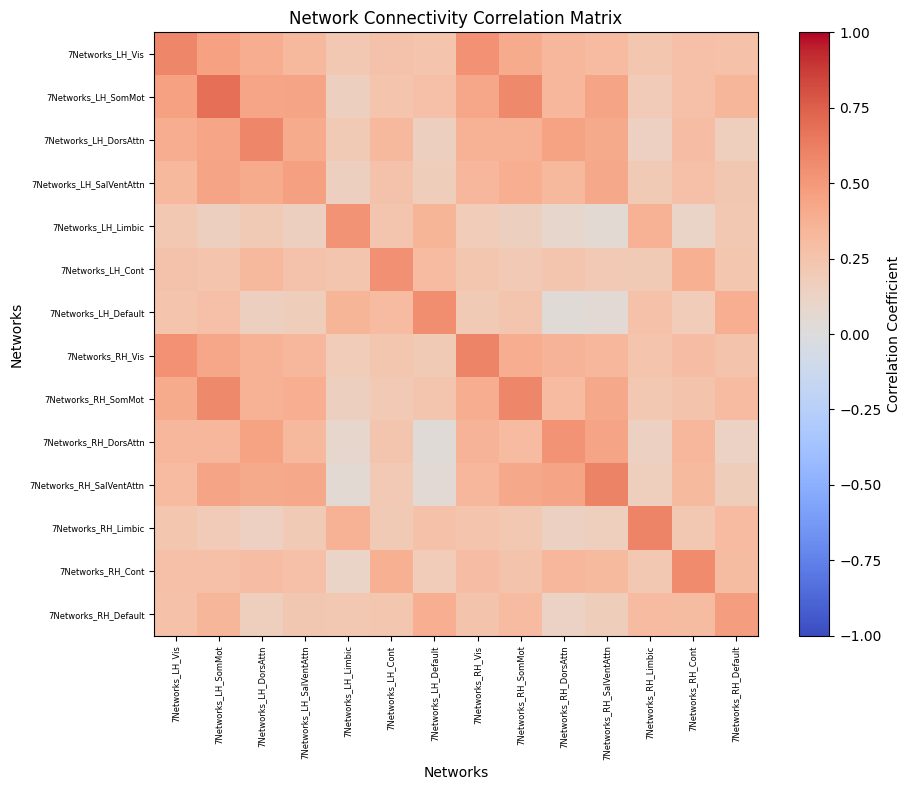

In [50]:
def calculate_and_plot_network_correlation_matrix(correlation_matrix, network_indices, network_prefixes, output_path='Images/network_correlation_matrix.png', title=None):
    """Calculate and plot the average correlation matrix between networks with correlation values displayed."""
    
    # Initialize an empty matrix to hold the average correlation values
    network_correlation_matrix = np.zeros((len(network_prefixes), len(network_prefixes)))

    # Calculate the average correlation for each network pair
    for i, prefix_i in enumerate(network_prefixes):
        for j, prefix_j in enumerate(network_prefixes):
            indices_i = network_indices[prefix_i]
            indices_j = network_indices[prefix_j]
            
            print(f"Calculating correlation between {prefix_i} and {prefix_j}")

            # Extract the submatrix for the current network pair
            submatrix = correlation_matrix[np.ix_(indices_i, indices_j)]

            # Calculate the average value of the submatrix
            average_value = np.mean(submatrix)
            print(average_value )

            # Assign the average value to the corresponding entry in the new matrix
            network_correlation_matrix[i, j] = average_value

    # Plot the network correlation matrix
    plt.figure(figsize=(10, 8))
    plt.imshow(network_correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1)
    plt.colorbar(label='Correlation Coefficient')
    if title:
        plt.title(f'Network Connectivity Correlation Matrix: {title}')
    else:
        plt.title('Network Connectivity Correlation Matrix')
    plt.xlabel('Networks')
    plt.ylabel('Networks')
    plt.xticks(ticks=np.arange(len(network_prefixes)), labels=network_prefixes, rotation=90, fontsize=6)
    plt.yticks(ticks=np.arange(len(network_prefixes)), labels=network_prefixes, fontsize=6)
    plt.tight_layout()
    plt.savefig(output_path)
    plt.show()
    
    
    np.save(output_path.replace('.png', '.npy'), network_correlation_matrix)
    
    return network_correlation_matrix


# Example usage:
network_correlation_matrix = calculate_and_plot_network_correlation_matrix(
    correlation_matrix, network_indices, network_prefixes
)

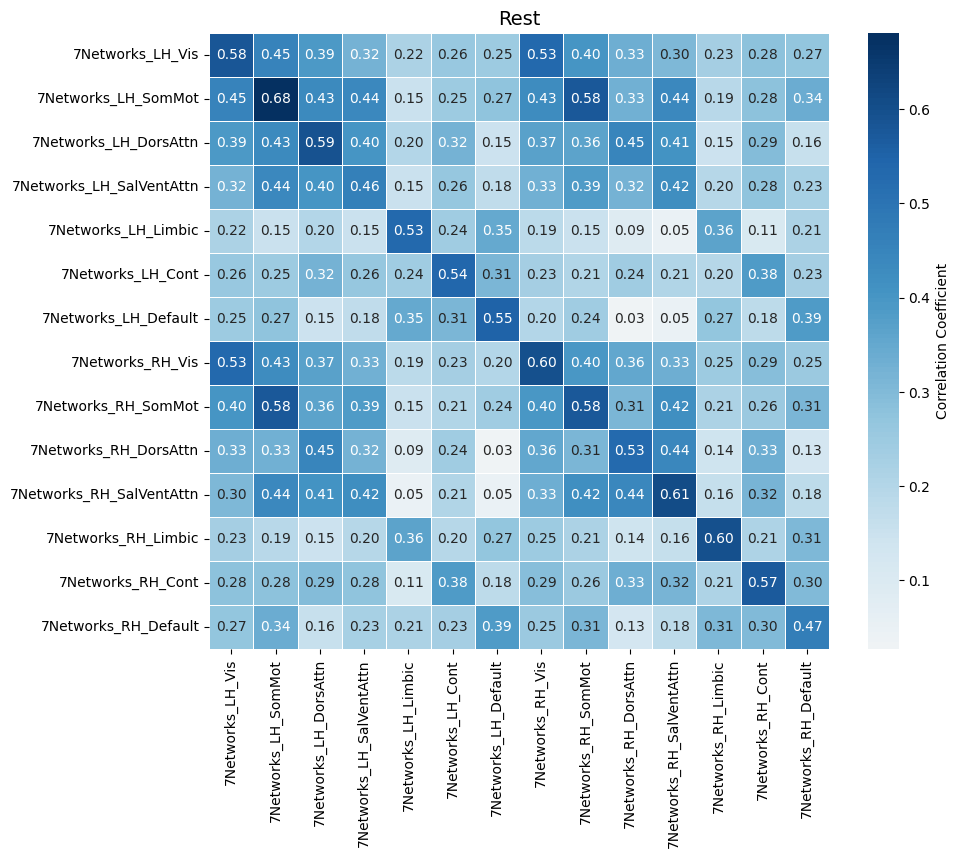

In [51]:
def plot_network_correlation_heatmap(network_correlation_matrix, network_prefixes, title, output_path=None):
    """
    Plots a heatmap for the network correlation matrix with annotations.

    Parameters:
    - network_correlation_matrix: numpy.ndarray
        The correlation matrix to be visualized.
    - network_prefixes: list
        List of network prefixes for labeling the axes.
    - title: str
        Title of the heatmap.
    - output_path: str, optional
        Path to save the heatmap image. If None, the plot is not saved.
    """
    import seaborn as sns
    import matplotlib.pyplot as plt

    # Create the heatmap
    fig, ax = plt.subplots(figsize=(10, 8))
    plt.title(title, fontsize=14)

    heatmap = sns.heatmap(network_correlation_matrix,
                          annot=True,
                          fmt='.2f',
                          linewidths=0.5,
                          cmap='RdBu',
                          center=0,
                          xticklabels=network_prefixes,
                          yticklabels=network_prefixes,
                          cbar_kws={'label': 'Correlation Coefficient'},
                          ax=ax)

    # Save the plot if output_path is provided
    if output_path:
        plt.savefig(output_path)

    # Display the plot
    plt.show()

# Example usage:
plot_network_correlation_heatmap(network_correlation_matrix, network_prefixes, title, output_path)


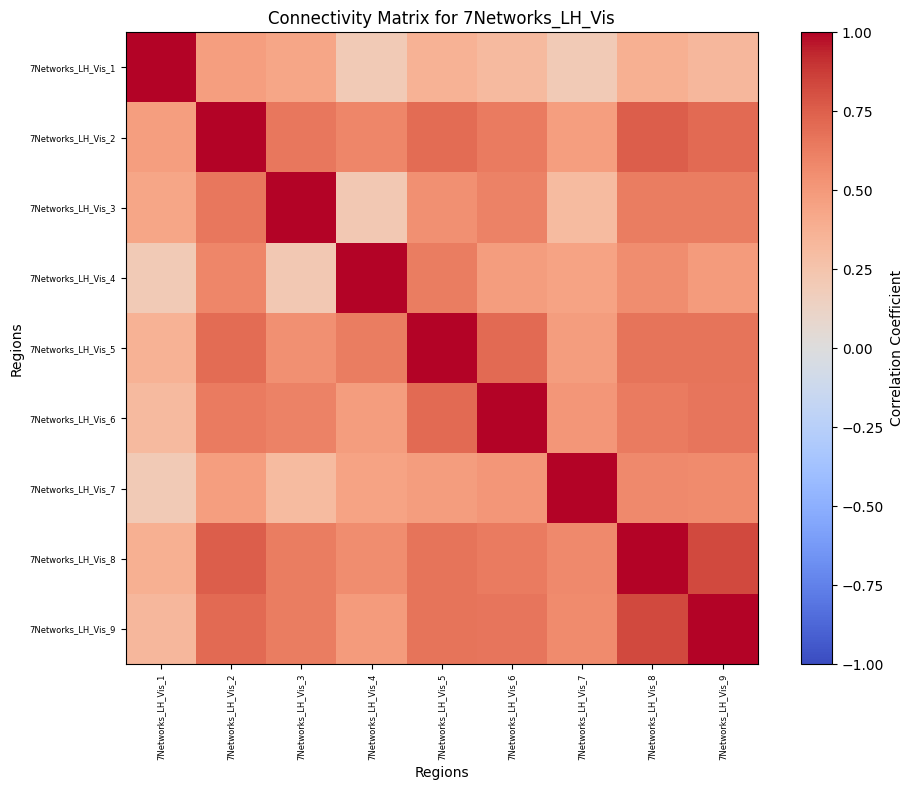

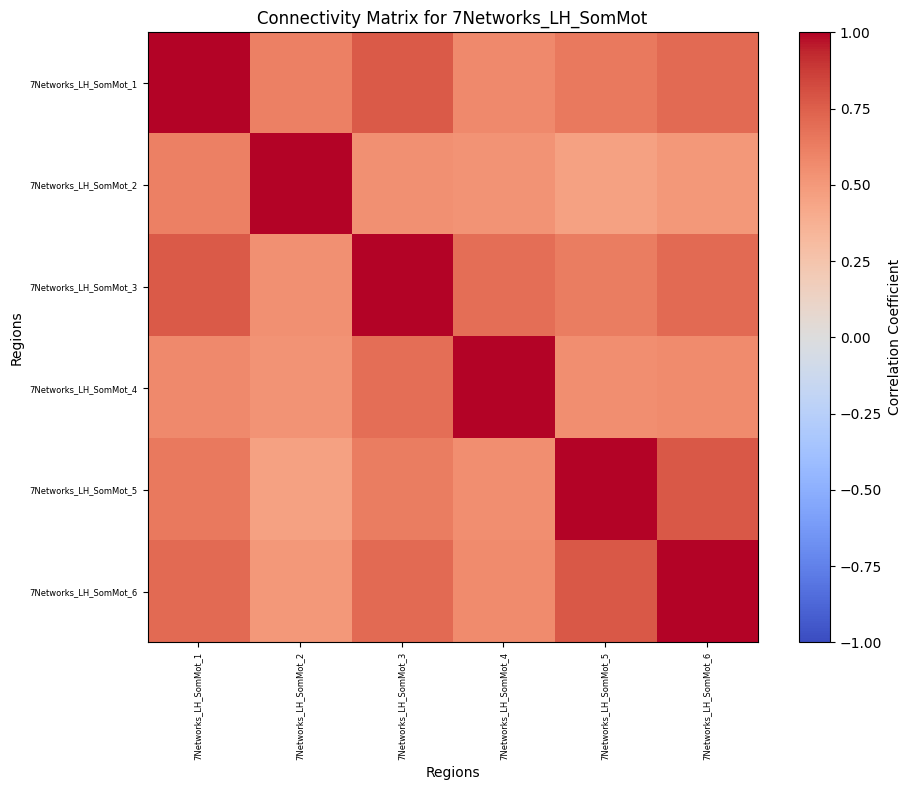

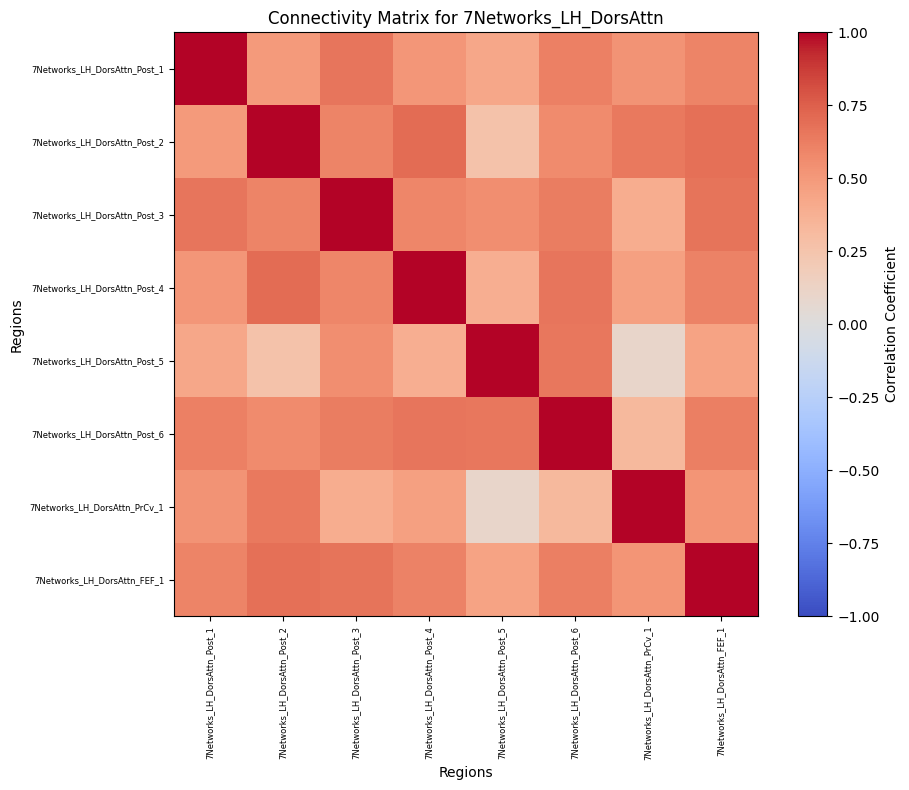

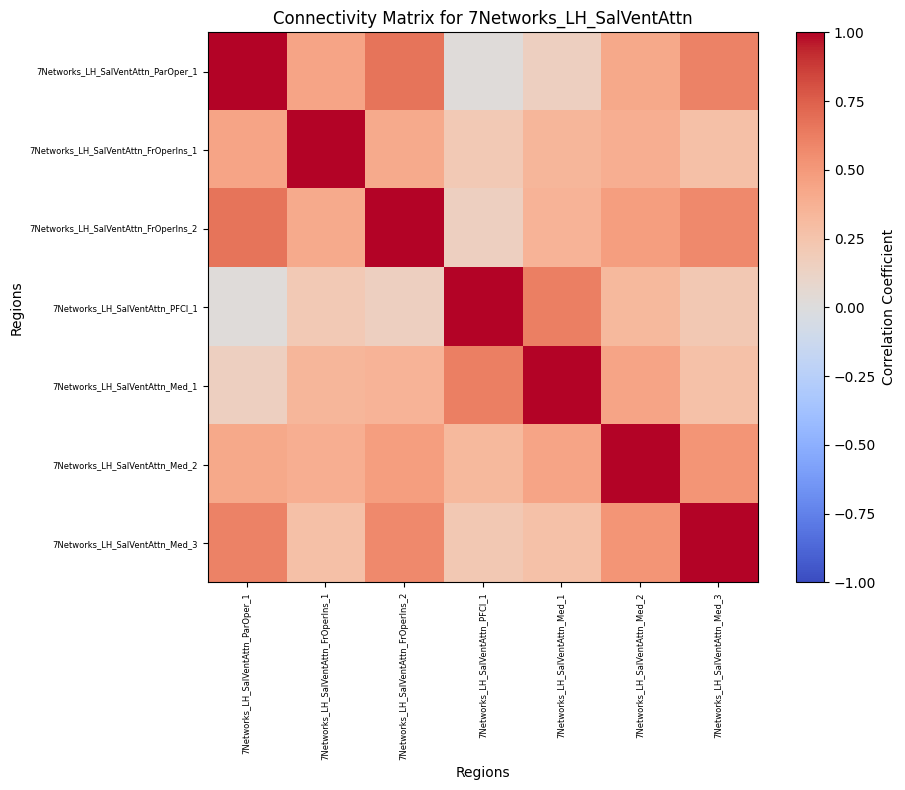

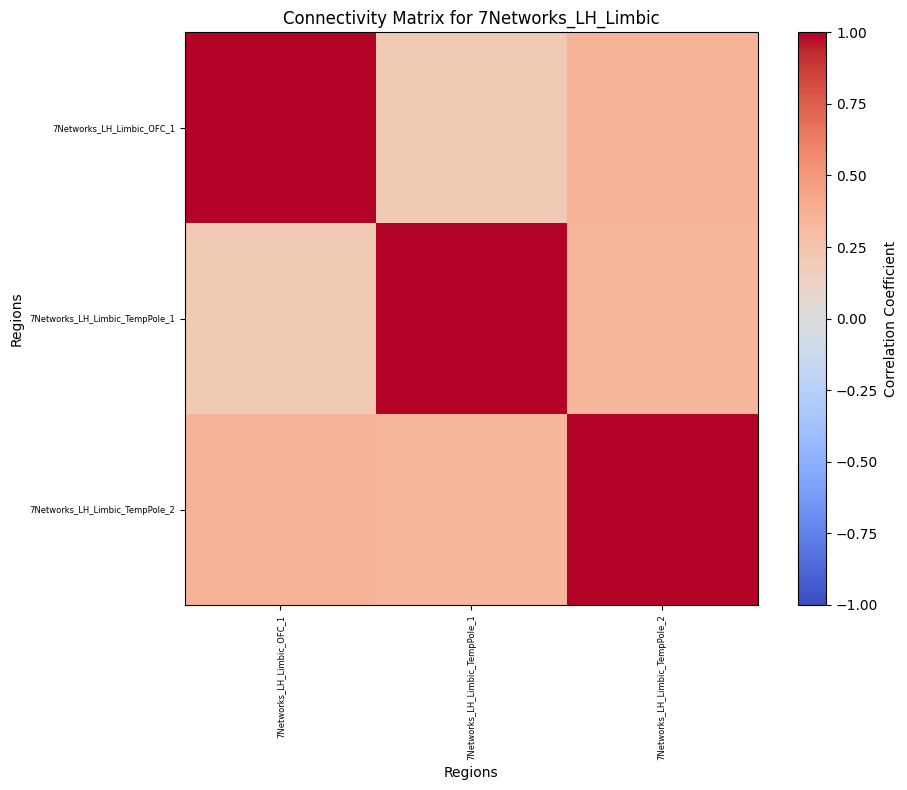

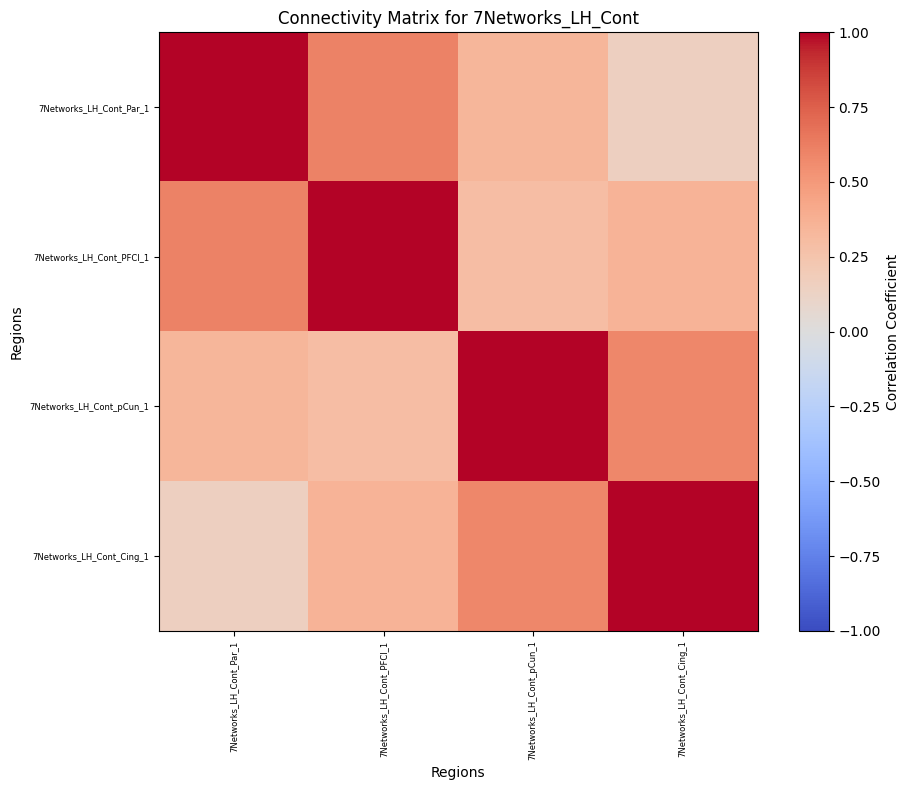

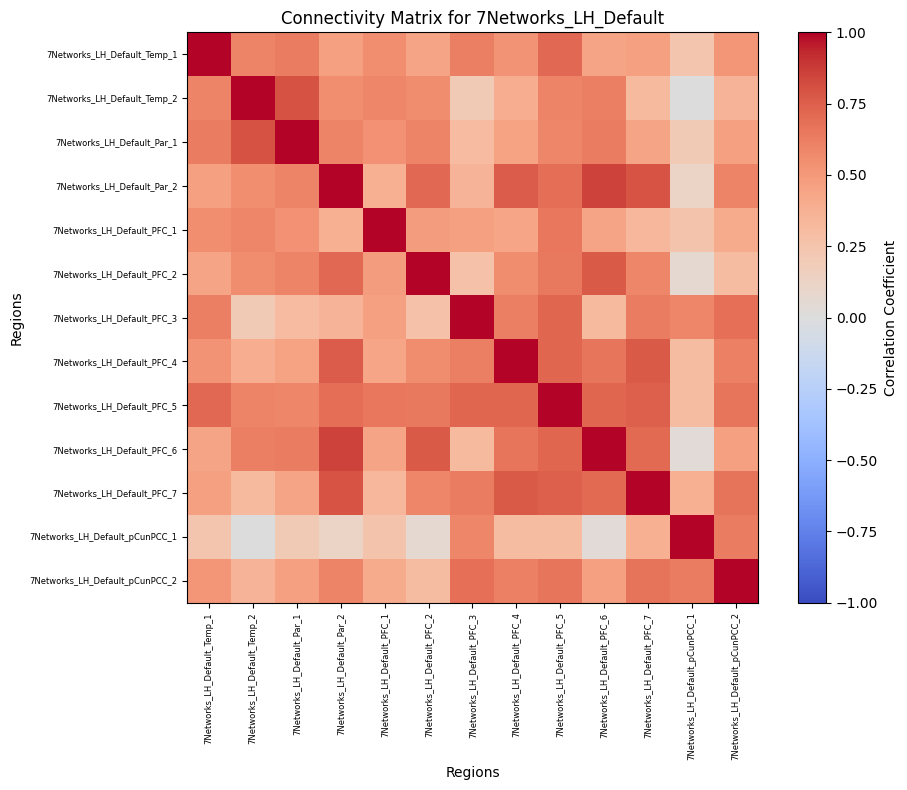

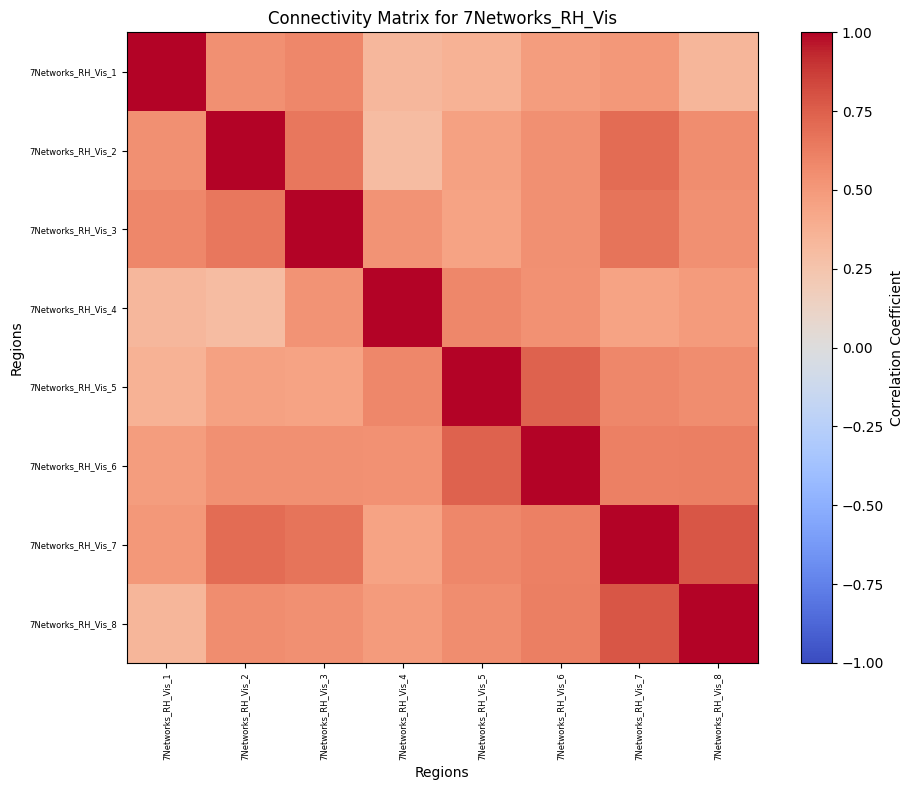

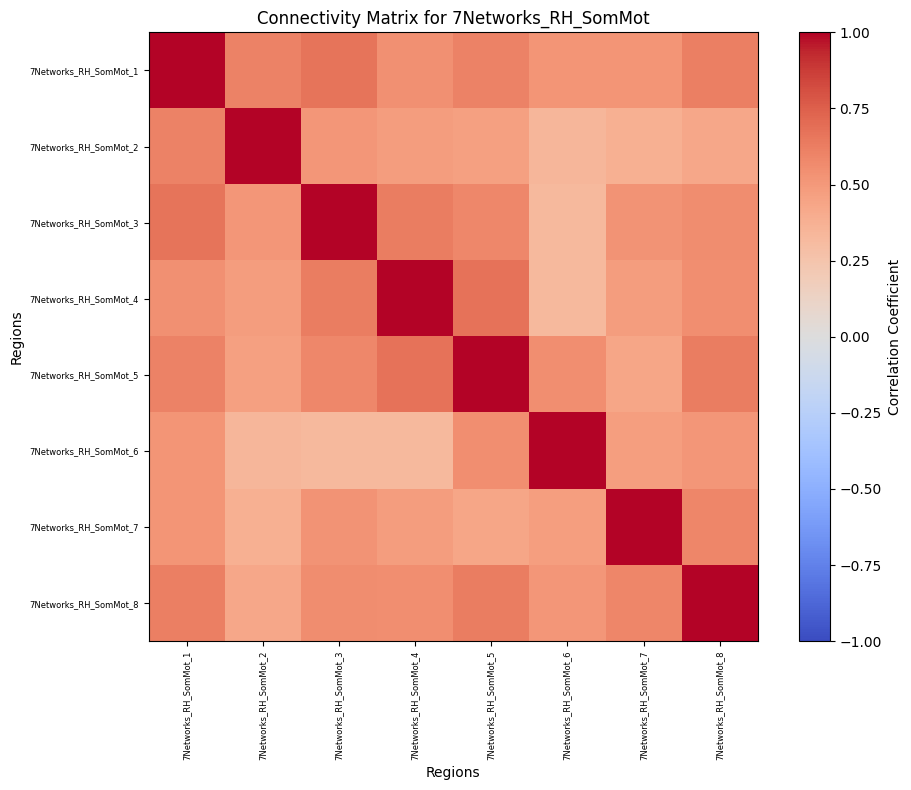

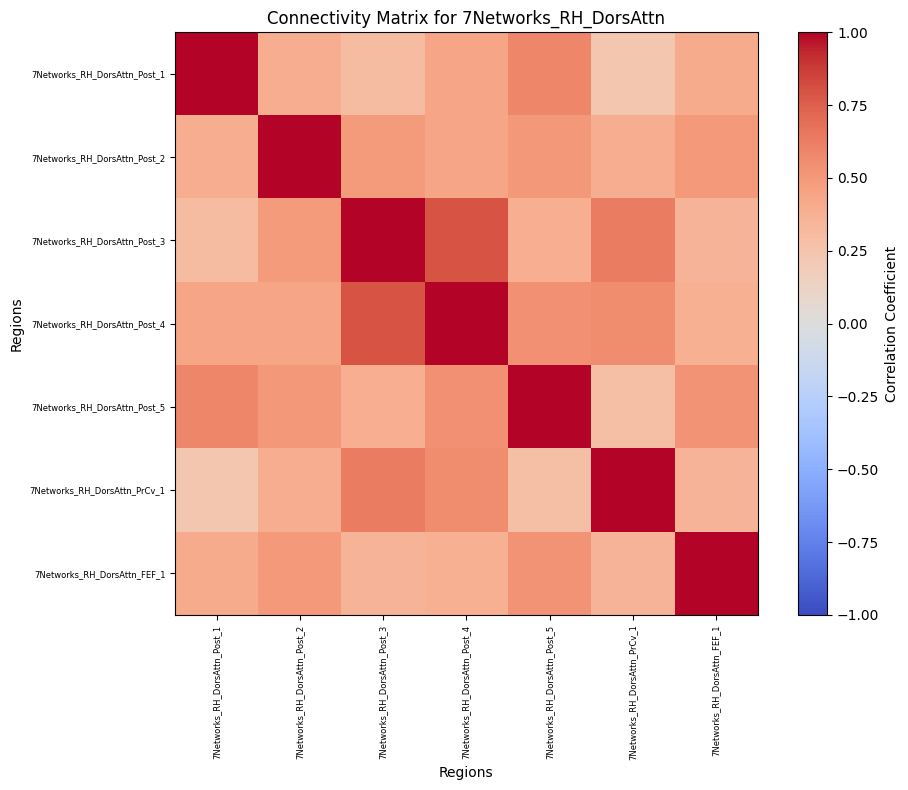

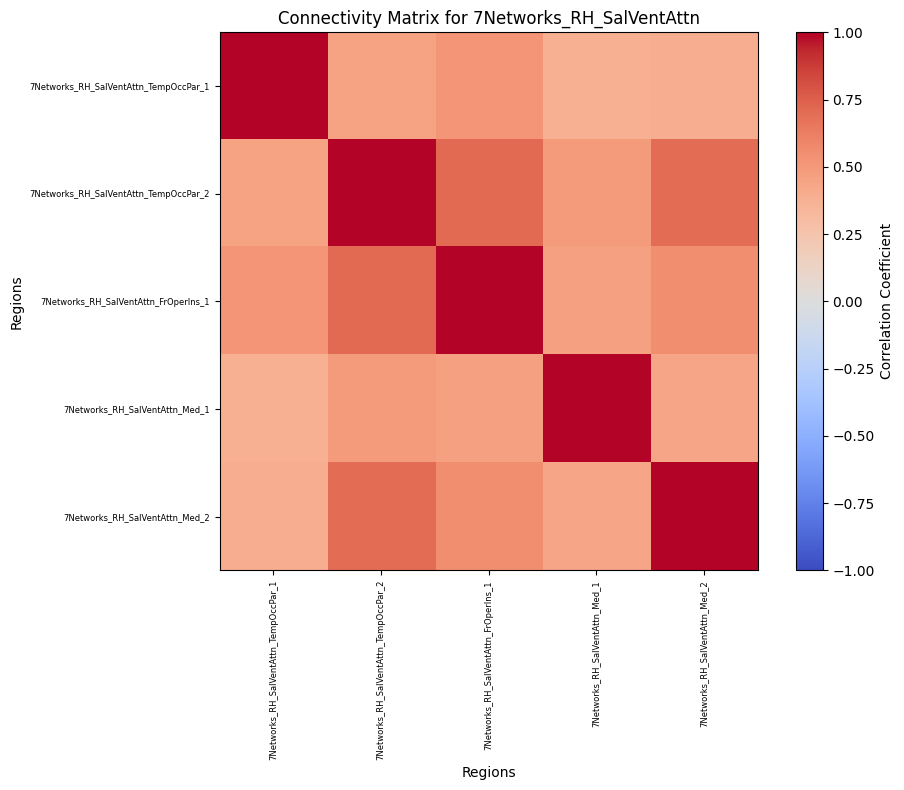

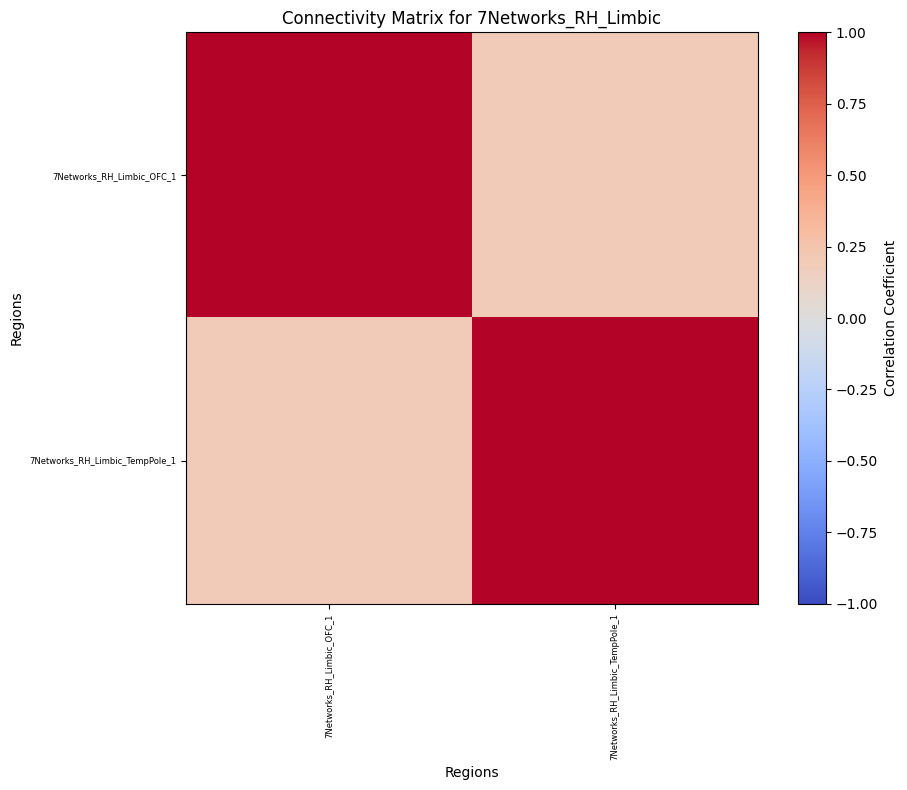

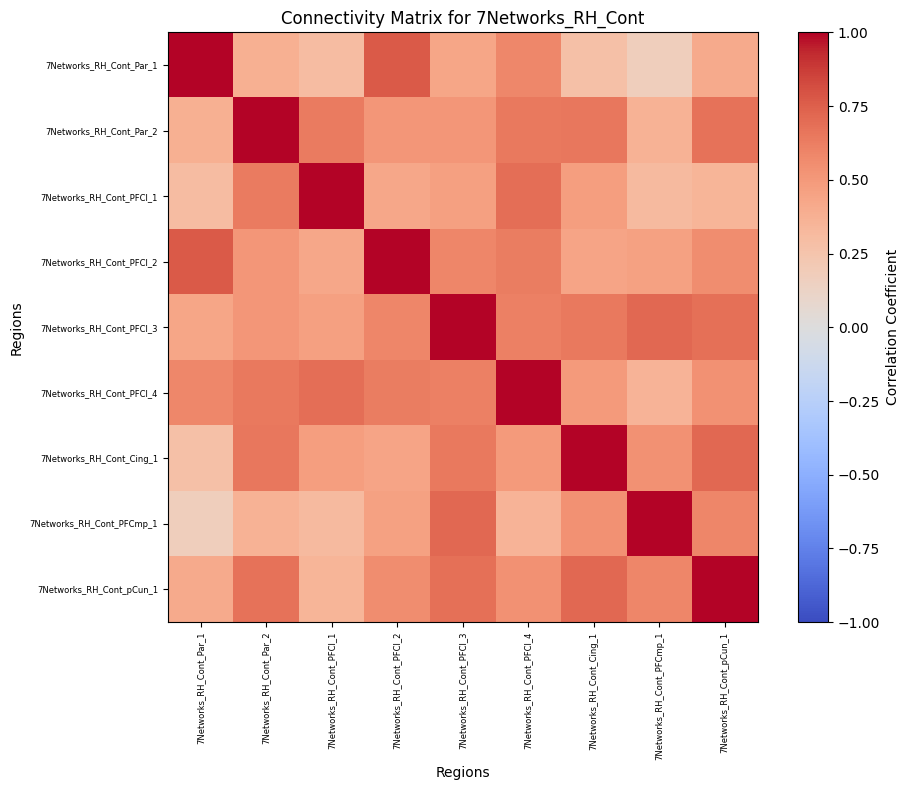

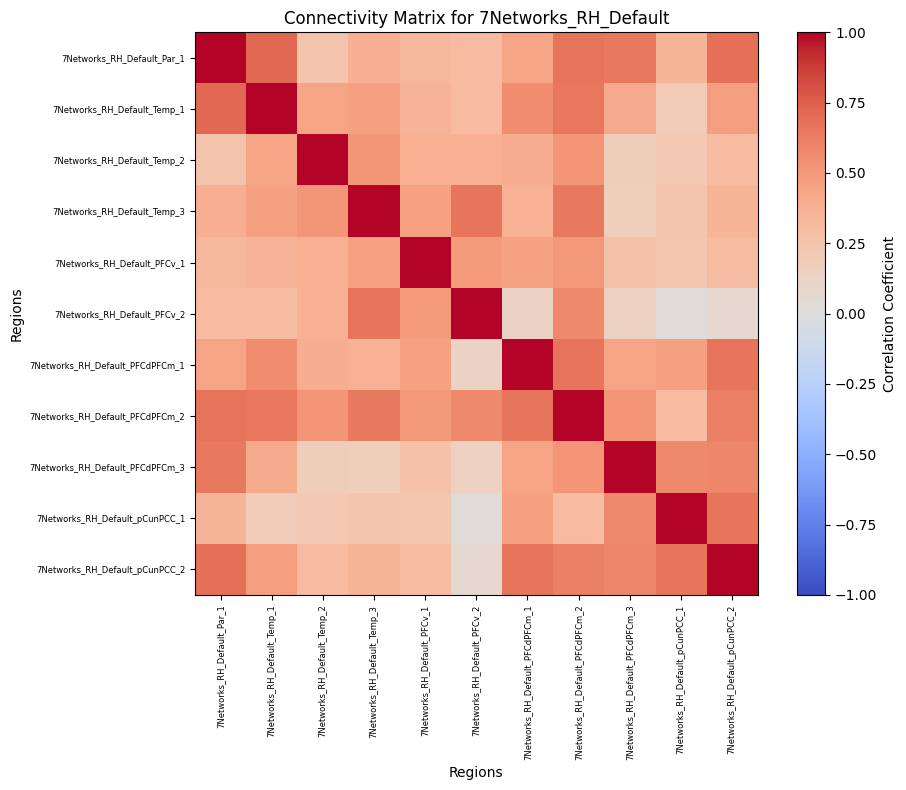

In [43]:
def plot_network_connectivity_matrix(network_prefixes, network_indices, time_series, region_names, output_dir='Images', title=None):
    """Plots the connectivity matrix for each network based on the time series data."""
    for network_to_analyze in network_prefixes:
        # Get the indices of the regions in the specified network
        region_indices = network_indices[network_to_analyze]

        # Extract the time series for these regions
        network_time_series = time_series[:, region_indices]

        # Calculate the Pearson correlation matrix for the network's regions
        network_correlation_matrix = np.corrcoef(network_time_series.T)

        # Plot the network correlation matrix
        plt.figure(figsize=(10, 8))
        plt.imshow(network_correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1)
        plt.colorbar(label='Correlation Coefficient')
        plot_title = title if title else f'Connectivity Matrix for {network_to_analyze}'
        plt.title(plot_title)
        plt.xlabel('Regions')
        plt.ylabel('Regions')
        plt.xticks(ticks=np.arange(len(region_indices)), labels=[region_names[i] for i in region_indices], rotation=90, fontsize=6)
        plt.yticks(ticks=np.arange(len(region_indices)), labels=[region_names[i] for i in region_indices], fontsize=6)
        plt.tight_layout()
        plt.savefig(f'{output_dir}/connectivity_matrix_{network_to_analyze}.png')
        plt.show()

# Example usage:
plot_network_connectivity_matrix(network_prefixes, network_indices, time_series, region_names)


In [44]:

# Identify Subjects
subjects = ['sub-12', 'sub-13', 'sub-14', 'sub-16']

# Define paths for different conditions
condition_paths = [task_graz_files, neurowMI_files, rest_files]

# Create a list to store the condition correlation matrices
condition_matrixes = [] 

# Save titles
titles = ['Task Graz', 'NeurowMI', 'Rest']

def process_conditions(subjects, condition_paths, atlas_img, condition_matrixes):
    """ Processes fMRI files for multiple conditions and subjects, calculates average correlation matrices,
    and returns the results."""

    for path in condition_paths:
        temp = []
        for subject in subjects:
            average_correlation_matrix = np.zeros((100,100))
            subject_files = [file for file in path if subject in file]
            for file in tqdm(subject_files, desc=f"Processing {subject} fMRI files"):
                fmri_img = nib.load(file)
                time_series = extract_time_series(fmri_img, atlas_img)
                correlation_matrix = np.corrcoef(time_series.T)
                average_correlation_matrix += correlation_matrix
                
            # Divide by the number of files to get the average
            average_correlation_matrix /= len(subject_files)
            temp.append(average_correlation_matrix)
            print("Processed subject:", subject)
            
        average_correlation_matrix = np.mean(temp, axis=0)
        condition_matrixes.append(average_correlation_matrix)
        print("Processed condition:", path)

    return condition_matrixes

In [ ]:
# Process all the conditions
condition_matrixes = process_conditions(subjects, condition_paths, atlas_img, condition_matrixes)

# Plot the average correlation matrix for each condition with titles
for matrix, title in zip(condition_matrixes, titles):
    plot_network_correlation_heatmap(matrix, region_names, title)
    
# Save the condition matrices
np.save('Matrices/condition_matrixes.npy', condition_matrixes)

# Assuming condition_matrixes contains the three condition matrices
condition_matrix_1 = condition_matrixes[0]
condition_matrix_2 = condition_matrixes[1]
condition_matrix_3 = condition_matrixes[2]

# Statistical Comparison
diff_1_2 = np.linalg.norm(condition_matrix_1 - condition_matrix_2)
diff_1_3 = np.linalg.norm(condition_matrix_1 - condition_matrix_3)
diff_2_3 = np.linalg.norm(condition_matrix_2 - condition_matrix_3)

print(f'Difference between Condition 1 and 2: {diff_1_2}')
print(f'Difference between Condition 1 and 3: {diff_1_3}')
print(f'Difference between Condition 2 and 3: {diff_2_3}')

# Element-wise Comparison
are_equal_1_2 = np.array_equal(condition_matrix_1, condition_matrix_2)
are_equal_1_3 = np.array_equal(condition_matrix_1, condition_matrix_3)
are_equal_2_3 = np.array_equal(condition_matrix_2, condition_matrix_3)

print(f'Condition 1 and 2 are equal: {are_equal_1_2}')
print(f'Condition 1 and 3 are equal: {are_equal_1_3}')
print(f'Condition 2 and 3 are equal: {are_equal_2_3}')

Calculating correlation between 7Networks_LH_Vis and 7Networks_LH_Vis
0.6416959296569902
Calculating correlation between 7Networks_LH_Vis and 7Networks_LH_SomMot
0.5057452949832979
Calculating correlation between 7Networks_LH_Vis and 7Networks_LH_DorsAttn
0.4820481277454177
Calculating correlation between 7Networks_LH_Vis and 7Networks_LH_SalVentAttn
0.39830274726156306
Calculating correlation between 7Networks_LH_Vis and 7Networks_LH_Limbic
0.2752427390349619
Calculating correlation between 7Networks_LH_Vis and 7Networks_LH_Cont
0.3942319042296927
Calculating correlation between 7Networks_LH_Vis and 7Networks_LH_Default
0.34071820867846814
Calculating correlation between 7Networks_LH_Vis and 7Networks_RH_Vis
0.6256682087419557
Calculating correlation between 7Networks_LH_Vis and 7Networks_RH_SomMot
0.4981888772267307
Calculating correlation between 7Networks_LH_Vis and 7Networks_RH_DorsAttn
0.477045828629222
Calculating correlation between 7Networks_LH_Vis and 7Networks_RH_SalVentAttn

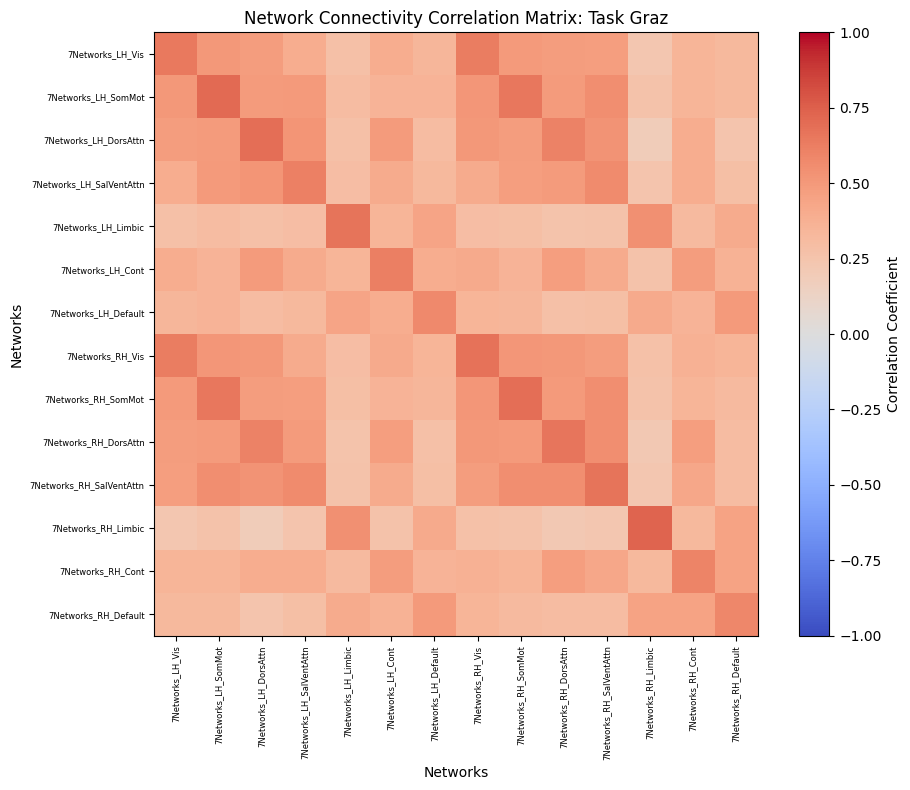

Calculating correlation between 7Networks_LH_Vis and 7Networks_LH_Vis
0.6508867306738815
Calculating correlation between 7Networks_LH_Vis and 7Networks_LH_SomMot
0.5339200382287969
Calculating correlation between 7Networks_LH_Vis and 7Networks_LH_DorsAttn
0.5509957205208083
Calculating correlation between 7Networks_LH_Vis and 7Networks_LH_SalVentAttn
0.4681301630535853
Calculating correlation between 7Networks_LH_Vis and 7Networks_LH_Limbic
0.34564166268800056
Calculating correlation between 7Networks_LH_Vis and 7Networks_LH_Cont
0.4670280185154982
Calculating correlation between 7Networks_LH_Vis and 7Networks_LH_Default
0.38376433042775737
Calculating correlation between 7Networks_LH_Vis and 7Networks_RH_Vis
0.6428749873828761
Calculating correlation between 7Networks_LH_Vis and 7Networks_RH_SomMot
0.50934826099478
Calculating correlation between 7Networks_LH_Vis and 7Networks_RH_DorsAttn
0.53080867644699
Calculating correlation between 7Networks_LH_Vis and 7Networks_RH_SalVentAttn
0.

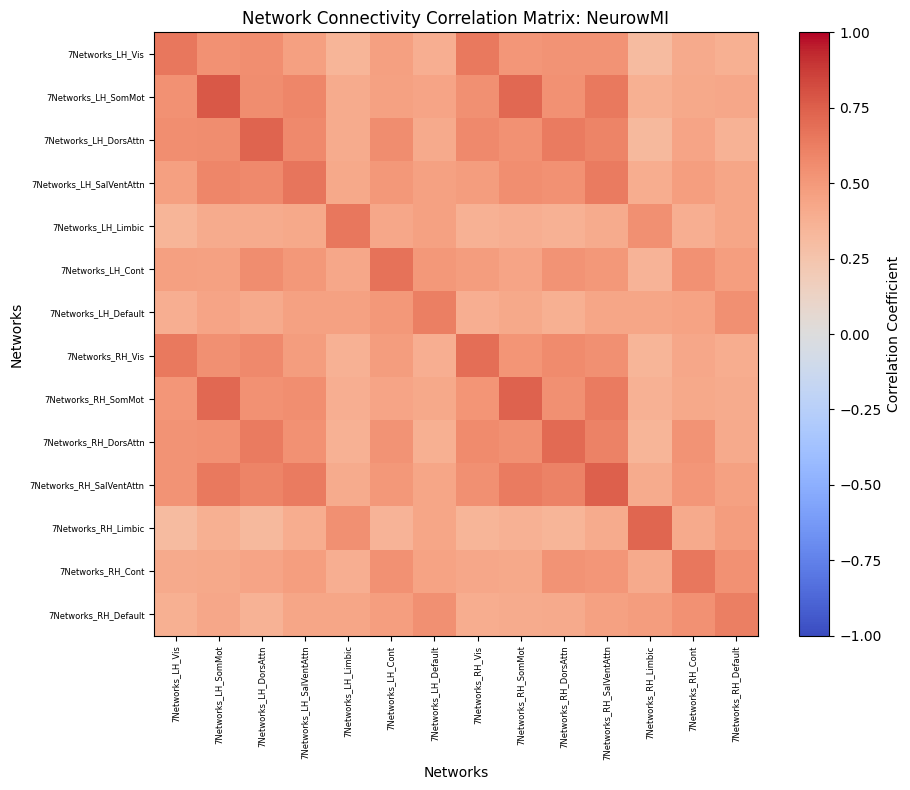

Calculating correlation between 7Networks_LH_Vis and 7Networks_LH_Vis
0.7101150922799272
Calculating correlation between 7Networks_LH_Vis and 7Networks_LH_SomMot
0.5342457965870773
Calculating correlation between 7Networks_LH_Vis and 7Networks_LH_DorsAttn
0.5837865277736266
Calculating correlation between 7Networks_LH_Vis and 7Networks_LH_SalVentAttn
0.48636811202648256
Calculating correlation between 7Networks_LH_Vis and 7Networks_LH_Limbic
0.38484402769590886
Calculating correlation between 7Networks_LH_Vis and 7Networks_LH_Cont
0.43659339269120656
Calculating correlation between 7Networks_LH_Vis and 7Networks_LH_Default
0.4173909994594497
Calculating correlation between 7Networks_LH_Vis and 7Networks_RH_Vis
0.7103147862702731
Calculating correlation between 7Networks_LH_Vis and 7Networks_RH_SomMot
0.5273119683797352
Calculating correlation between 7Networks_LH_Vis and 7Networks_RH_DorsAttn
0.5797641747350623
Calculating correlation between 7Networks_LH_Vis and 7Networks_RH_SalVentAt

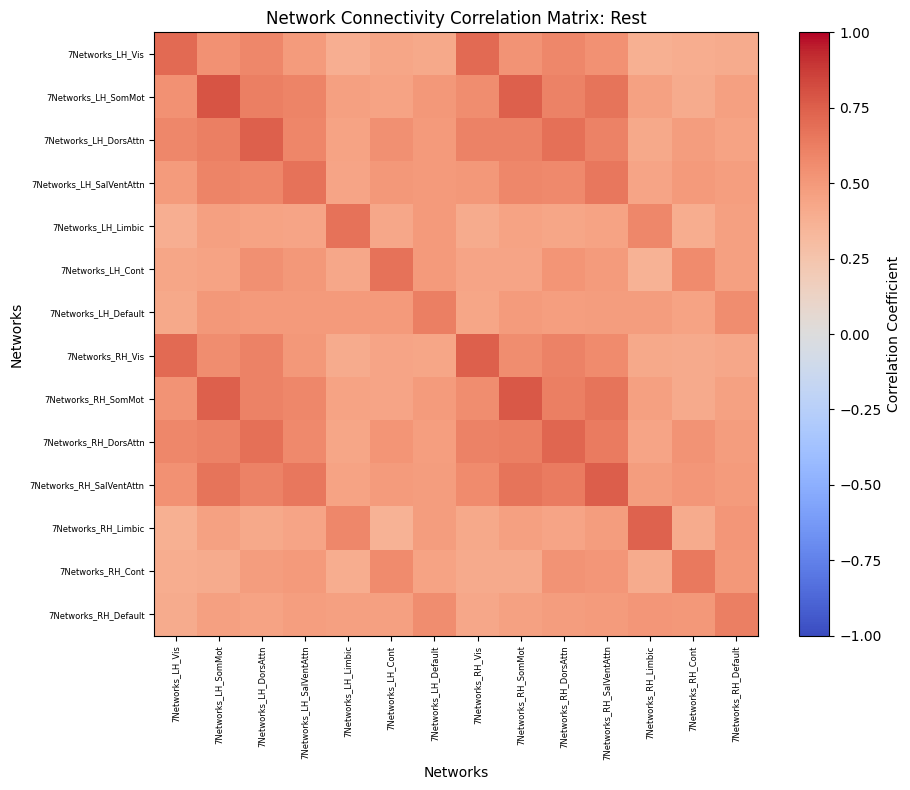

In [57]:
# Apply calculate_and_plot_network_correlation_matrix to all conditions and save as .npy
for matrix, title in zip(condition_matrixes, titles):
    output_path = f'Images/network_correlation_matrix_{title}.png'
    npy_path = f'Images/network_correlation_matrix_{title}.npy'
    network_correlation_matrix = calculate_and_plot_network_correlation_matrix(
        matrix, network_indices, network_prefixes, output_path=output_path, title=title
    )
    np.save(npy_path, network_correlation_matrix)

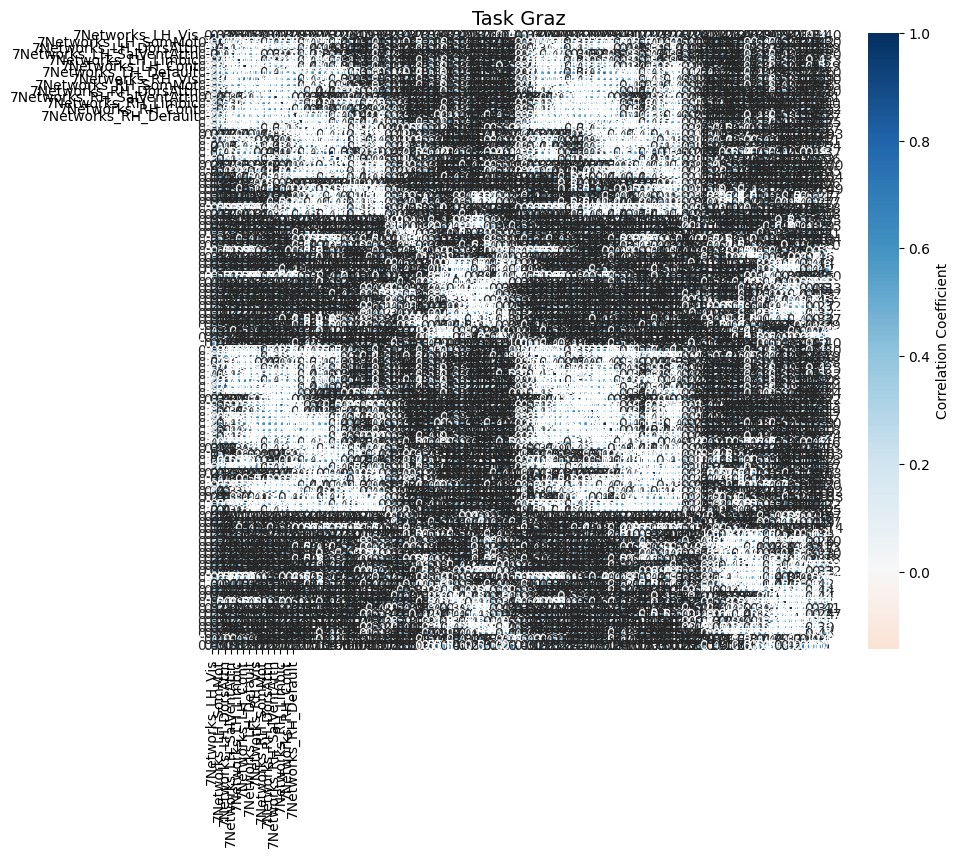

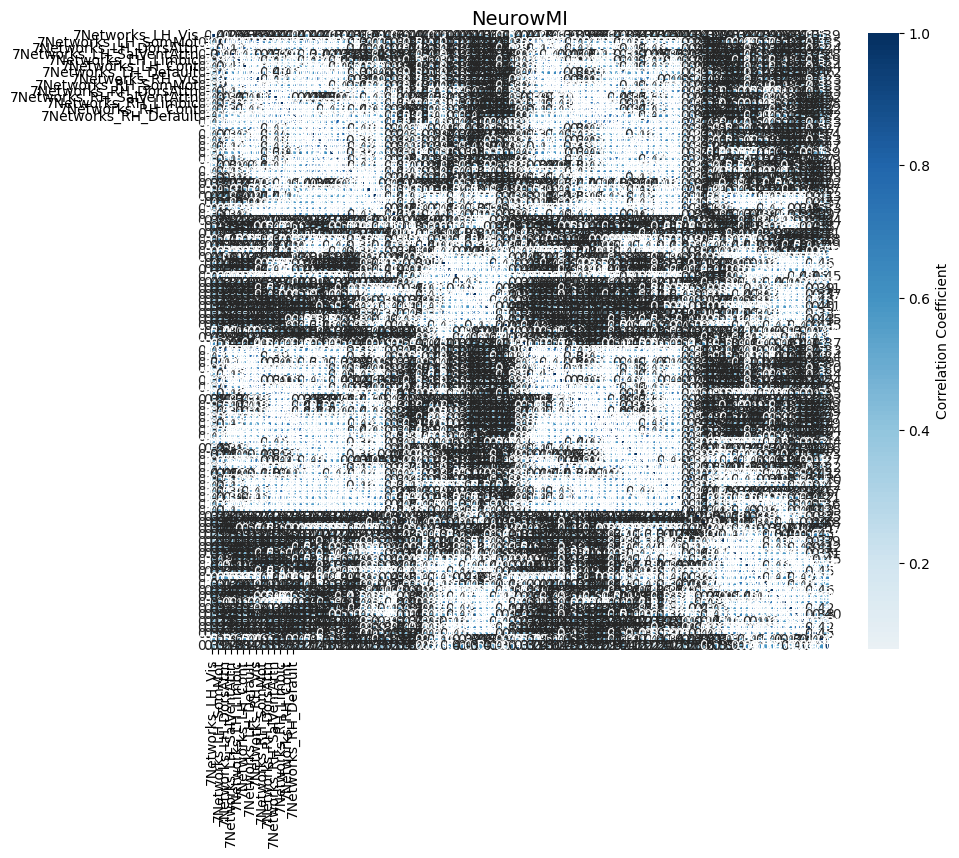

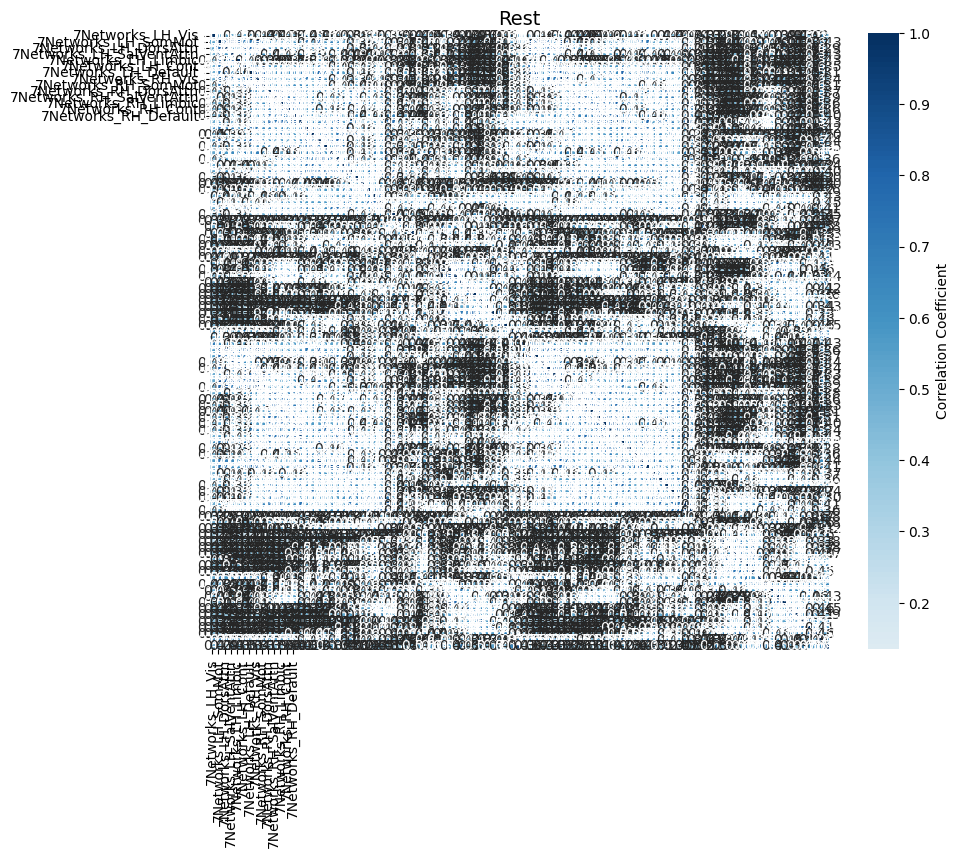

In [60]:
# Apply plot_network_correlation_heatmap to all conditions and save as .png
for matrix, title in zip(condition_matrixes, titles):
    output_path = f'Images/network_correlation_heatmap_{title}.png'
    plot_network_correlation_heatmap(matrix, network_prefixes, title, output_path=output_path)


In [47]:
# Save the condition matrices
np.save('Matrices/condition_matrixes.npy', condition_matrixes)
